**Introduction**


-This report presents the development and evaluation of predictive models to identify customers at risk of churn. The goal is to enable the business to proactively retain valuable customers by targeting those most likely to leave.



In [88]:
# 📦 Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

import warnings
warnings.filterwarnings("ignore")

# Configure default plotting
%matplotlib inline
sns.set(style='whitegrid')


In [89]:
# Load each workbook
demographics = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Demographics')  # workbook1
transactions = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Transaction_History')    # workbook2
customer_service = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Service')   # workbook3
online_activity = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Online_Activity')     # workbook4
churn_status = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Churn_Status')           # workbook5


### Comprehensive Data Review & EDA Report

***Forage Lloyds Virtual Internship***

***Predicting Customer Churn***
    
### 1. Data Gathering and Dataset Overview

The following five datasets were provided for analysis:

Customer_Demographics -- Contains personal details like age, gender, marital status, and income level

Transaction_History -- Records customer purchases, including date, amount, and product category 

Customer_Service -- Logs customer service interactions and whether the issue was resolved

Online_Activity -- Tracks login frequency and usage patterns of digital services 

Churn_Status -- The target label indicating if a customer has churned (1) or remained (0)

### 2. Dataset Selection Criteria & Rationale

Customer_Demographics -- Demographics such as age, gender, and income may influence customer loyalty. 

Transaction_History -- Purchase frequency, spending patterns, and product preferences are strong behavioral indicators of churn

Customer_Service -- Frequent/unresolved complaints suggest dissatisfaction—a major churn driver

Online Activity -- Inactivity or low digital engagement is a strong predictor of churn

Churn Status -- This is the target variable used for supervised learning.

All datasets were selected, as they contribute complementary features crucial to understanding customer behavior

In [100]:
# 📌 Step 3: Preview the Data
print("Transactions:")
display(transactions.head())

print("Demographics:")
display(demographics.head())

print("Customer_Service:")
display(customer_service.head())

print("Online_Activity:")
display(online_activity.head())

print("Churn_Status:")
display(churn_status.head())


Transactions:


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


Demographics:


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


Customer_Service:


,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


Online_Activity:


,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


Churn_Status:


,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [101]:
# 📌 Step 5: Merging the Data

# First, ensure consistent CustomerID format across all datasets
transactions['CustomerID'] = transactions['CustomerID'].astype(str)
demographics['CustomerID'] = demographics['CustomerID'].astype(str)
customer_service['CustomerID'] = customer_service['CustomerID'].astype(str)
online_activity['CustomerID']= online_activity['CustomerID'].astype(str)
churn_status['CustomerID']=churn_status['CustomerID'].astype(str)


In [102]:
# Step-by-step merge using left join on CustomerID
df = transactions.merge(demographics, on='CustomerID', how='left')
df = df.merge(customer_service, on='CustomerID', how='left')
df = df.merge(online_activity, on='CustomerID', how='left')
df = df.merge(churn_status, on='CustomerID', how='left')

# Check the shape and preview the final merged dataset
print("Merged dataset shape:", df.shape)
df.head()

Merged dataset shape: (6812, 17)


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory,Age,Gender,MaritalStatus,IncomeLevel,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,7194,2022-03-27,416.50,Electronics,62,M,Single,Low,6363.0,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,7250,2022-08-08,54.96,Clothing,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,9660,2022-07-25,197.50,Electronics,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,2998,2022-01-25,101.31,Furniture,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,1228,2022-07-24,397.37,Clothing,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


In [103]:
df.to_csv('merged_customer_data.csv', index=False)


In [104]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   object        
 1   TransactionID     6812 non-null   int64         
 2   TransactionDate   6812 non-null   datetime64[ns]
 3   AmountSpent       6812 non-null   float64       
 4   ProductCategory   6812 non-null   object        
 5   Age               6812 non-null   int64         
 6   Gender            6812 non-null   object        
 7   MaritalStatus     6812 non-null   object        
 8   IncomeLevel       6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     6812 non-null   datetime64[ns]
 14  LoginFrequency    6812 n

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory,Age,Gender,MaritalStatus,IncomeLevel,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
count,6812,6812.000000,6812,6812.000000,6812,6812.000000,6812,6812,6812,5204.000000,5204,5204,5204,6812,6812.000000,6812,6812.000000
unique,1000,NaN,NaN,NaN,5,NaN,2,4,3,NaN,NaN,3,2,NaN,NaN,3,NaN
top,908,NaN,NaN,NaN,Books,NaN,F,Widowed,High,NaN,NaN,Feedback,Resolved,NaN,NaN,Online Banking,NaN
freq,18,NaN,NaN,NaN,1408,NaN,3580,1896,2340,NaN,NaN,1921,2693,NaN,NaN,2419,NaN
mean,NaN,5497.323253,2022-07-01 02:11:29.136817408,251.620527,NaN,43.274516,NaN,NaN,NaN,5921.861261,2022-07-01 16:31:10.561106944,NaN,NaN,2023-07-06 04:56:47.633587712,25.724310,NaN,0.198473
min,NaN,1000.000000,2022-01-01 00:00:00,5.180000,NaN,18.000000,NaN,NaN,NaN,2015.000000,2022-01-01 00:00:00,NaN,NaN,2023-01-01 00:00:00,1.000000,NaN,0.000000
25%,NaN,3223.500000,2022-04-02 00:00:00,127.100000,NaN,30.000000,NaN,NaN,NaN,3873.250000,2022-04-07 00:00:00,NaN,NaN,2023-04-12 00:00:00,14.000000,NaN,0.000000
50%,NaN,5515.000000,2022-07-01 00:00:00,251.845000,NaN,44.000000,NaN,NaN,NaN,5903.000000,2022-07-02 00:00:00,NaN,NaN,2023-07-13 00:00:00,26.000000,NaN,0.000000
75%,NaN,7675.250000,2022-09-30 00:00:00,375.280000,NaN,56.000000,NaN,NaN,NaN,7851.000000,2022-09-25 00:00:00,NaN,NaN,2023-10-01 00:00:00,38.000000,NaN,0.000000
max,NaN,9997.000000,2022-12-31 00:00:00,499.860000,NaN,69.000000,NaN,NaN,NaN,9997.000000,2022-12-30 00:00:00,NaN,NaN,2023-12-31 00:00:00,49.000000,NaN,1.000000


In [105]:
# Check for total number of duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [106]:
df.isnull().sum()


CustomerID             0
TransactionID          0
TransactionDate        0
AmountSpent            0
ProductCategory        0
Age                    0
Gender                 0
MaritalStatus          0
IncomeLevel            0
InteractionID       1608
InteractionDate     1608
InteractionType     1608
ResolutionStatus    1608
LastLoginDate          0
LoginFrequency         0
ServiceUsage           0
ChurnStatus            0
dtype: int64

***1,608 customers had no recorded customer service interactions — which is valid since not all customer will contact support***

In [108]:
df['InteractionID'] = df['InteractionID'].fillna('NoInteraction')
df['InteractionDate'] = df['InteractionDate'].fillna('NoDate')
df['InteractionType'] = df['InteractionType'].fillna('None')
df['ResolutionStatus'] = df['ResolutionStatus'].fillna('None')


In [109]:
df.isnull().sum()

CustomerID          0
TransactionID       0
TransactionDate     0
AmountSpent         0
ProductCategory     0
Age                 0
Gender              0
MaritalStatus       0
IncomeLevel         0
InteractionID       0
InteractionDate     0
InteractionType     0
ResolutionStatus    0
LastLoginDate       0
LoginFrequency      0
ServiceUsage        0
ChurnStatus         0
dtype: int64

In [110]:
# Dataset shape
print("Shape of the dataset:", df.shape)

# Column data types
print("\nData types:")
print(df.dtypes)

# First 5 rows
df.head()


Shape of the dataset: (6812, 17)

Data types:
CustomerID                  object
TransactionID                int64
TransactionDate     datetime64[ns]
AmountSpent                float64
ProductCategory             object
Age                          int64
Gender                      object
MaritalStatus               object
IncomeLevel                 object
InteractionID               object
InteractionDate             object
InteractionType             object
ResolutionStatus            object
LastLoginDate       datetime64[ns]
LoginFrequency               int64
ServiceUsage                object
ChurnStatus                  int64
dtype: object


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory,Age,Gender,MaritalStatus,IncomeLevel,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,7194,2022-03-27,416.50,Electronics,62,M,Single,Low,6363.0,2022-03-31 00:00:00,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,7250,2022-08-08,54.96,Clothing,65,M,Married,Low,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,9660,2022-07-25,197.50,Electronics,65,M,Married,Low,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,2998,2022-01-25,101.31,Furniture,65,M,Married,Low,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,1228,2022-07-24,397.37,Clothing,65,M,Married,Low,3329.0,2022-03-17 00:00:00,Inquiry,Resolved,2023-12-05,5,Website,1


In [111]:
df['InteractionDate'] = pd.to_datetime(df['InteractionDate'], errors='coerce')


In [112]:
print(df.dtypes)

CustomerID                  object
TransactionID                int64
TransactionDate     datetime64[ns]
AmountSpent                float64
ProductCategory             object
Age                          int64
Gender                      object
MaritalStatus               object
IncomeLevel                 object
InteractionID               object
InteractionDate     datetime64[ns]
InteractionType             object
ResolutionStatus            object
LastLoginDate       datetime64[ns]
LoginFrequency               int64
ServiceUsage                object
ChurnStatus                  int64
dtype: object


In [113]:
# Numerical summary
df.describe()


,TransactionID,TransactionDate,AmountSpent,Age,InteractionDate,LastLoginDate,LoginFrequency,ChurnStatus
count,6812.000000,6812,6812.000000,6812.000000,5204,6812,6812.000000,6812.000000
mean,5497.323253,2022-07-01 02:11:29.136817408,251.620527,43.274516,2022-07-01 16:31:10.561106944,2023-07-06 04:56:47.633587712,25.724310,0.198473
min,1000.000000,2022-01-01 00:00:00,5.180000,18.000000,2022-01-01 00:00:00,2023-01-01 00:00:00,1.000000,0.000000
25%,3223.500000,2022-04-02 00:00:00,127.100000,30.000000,2022-04-07 00:00:00,2023-04-12 00:00:00,14.000000,0.000000
50%,5515.000000,2022-07-01 00:00:00,251.845000,44.000000,2022-07-02 00:00:00,2023-07-13 00:00:00,26.000000,0.000000
75%,7675.250000,2022-09-30 00:00:00,375.280000,56.000000,2022-09-25 00:00:00,2023-10-01 00:00:00,38.000000,0.000000
max,9997.000000,2022-12-31 00:00:00,499.860000,69.000000,2022-12-30 00:00:00,2023-12-31 00:00:00,49.000000,1.000000
std,2584.768541,NaN,142.901693,15.286788,NaN,NaN,14.062032,0.398880


In [114]:
# Categorical summary
df.describe(include='object')

,CustomerID,ProductCategory,Gender,MaritalStatus,IncomeLevel,InteractionID,InteractionType,ResolutionStatus,ServiceUsage
count,6812,6812,6812,6812,6812,6812,6812,6812,6812
unique,1000,5,2,4,3,961,4,3,3
top,908,Books,F,Widowed,High,NoInteraction,Feedback,Resolved,Online Banking
freq,18,1408,3580,1896,2340,1608,1921,2693,2419


In [115]:
df.to_csv('cleaned_llyods_dataset.csv', index=False)

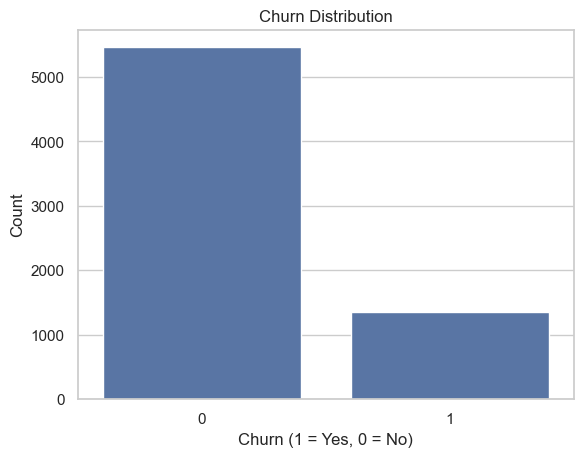

In [116]:
sns.countplot(x='ChurnStatus', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


In the Churn_Status dataset:

0 typically means the customer did not churn, i.e., they are still active with the company.

1 usually means the customer has churned, i.e., they stopped using the company's services (closed their account, unsubscribed, etc.).

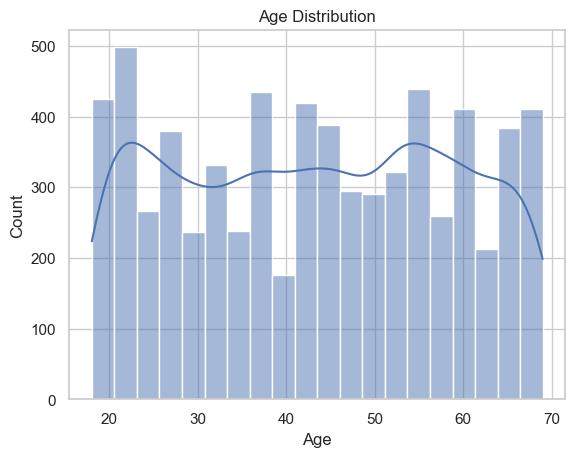

In [120]:
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.show()


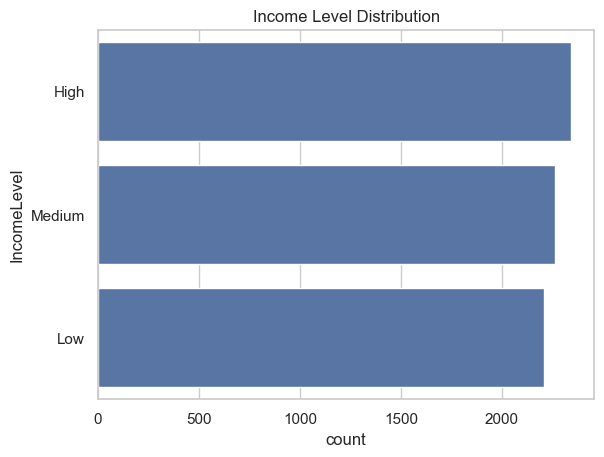

In [121]:
sns.countplot(y='IncomeLevel', data=df, order=df['IncomeLevel'].value_counts().index)
plt.title('Income Level Distribution')
plt.show()


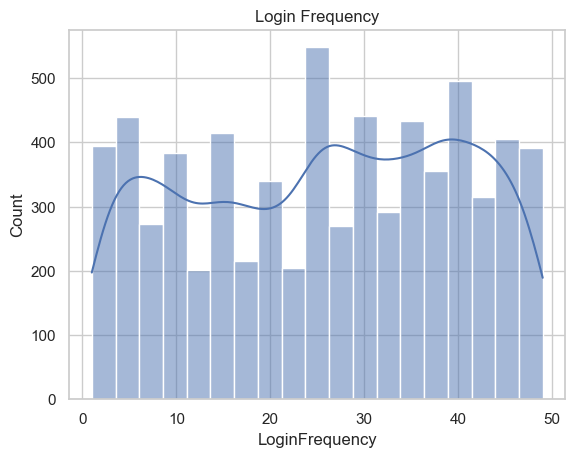

In [122]:
sns.histplot(df['LoginFrequency'], kde=True)
plt.title('Login Frequency')
plt.show()


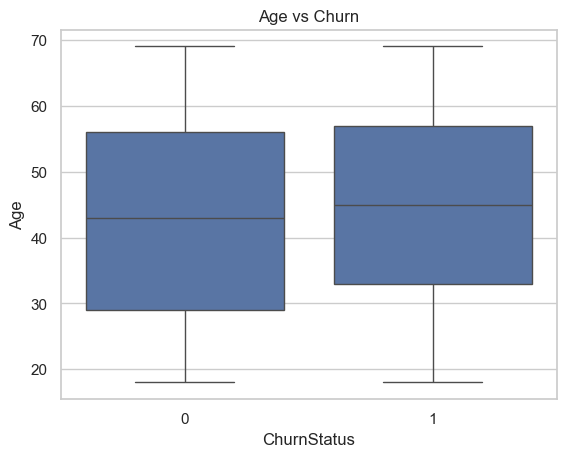

In [123]:
sns.boxplot(x='ChurnStatus', y='Age', data=df)
plt.title('Age vs Churn')
plt.show()


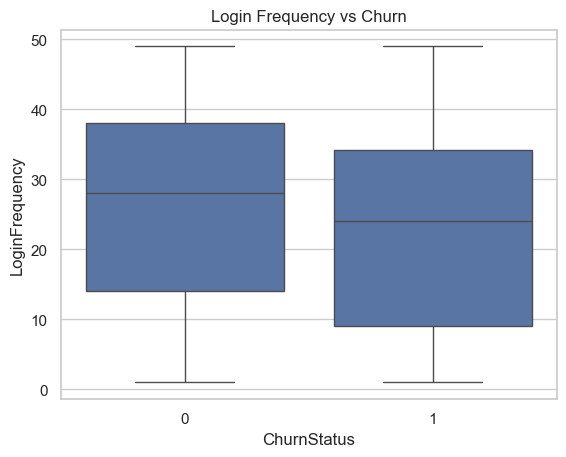

In [124]:
sns.boxplot(x='ChurnStatus', y='LoginFrequency', data=df)
plt.title('Login Frequency vs Churn')
plt.show()


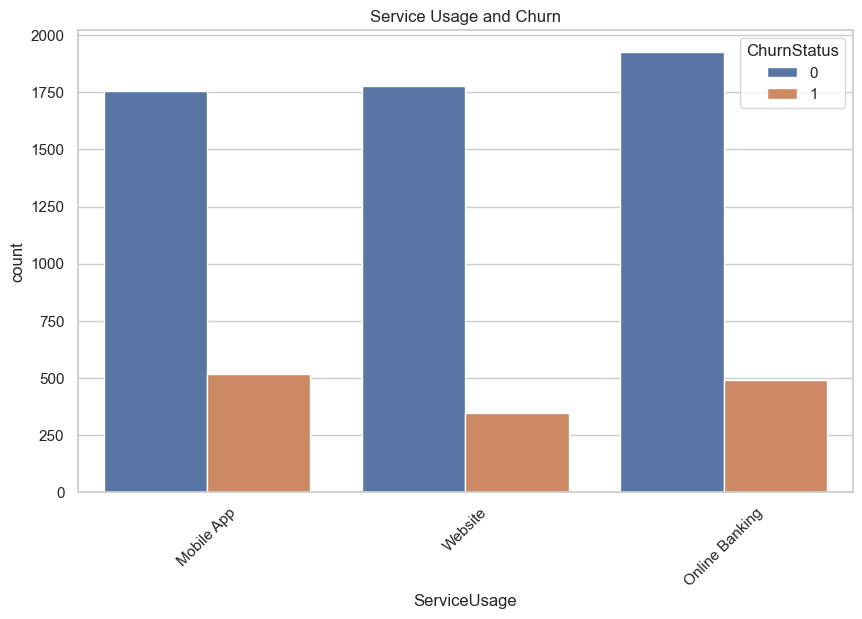

In [125]:
plt.figure(figsize=(10,6))
sns.countplot(x='ServiceUsage', hue='ChurnStatus', data=df)
plt.title('Service Usage and Churn')
plt.xticks(rotation=45)
plt.show()


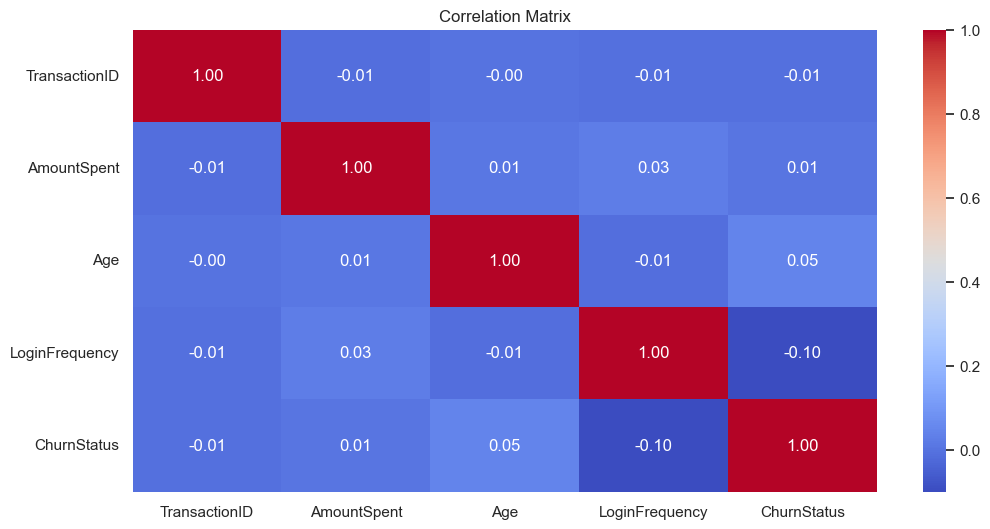

In [126]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### Key EDA Insights:

- Customers with lower login frequency tend to churn more.
- High service usage correlates with lower churn.
- Income level and age may have weak to moderate influence on churn.
- Churned users tend to have less recent logins and interactions.
- These insights suggest that customer engagement (logins, service usage) is a strong churn indicator.

#### 📌 Business Actions:
- Target low-engagement users with personalized campaigns.
- Promote digital service usage among low-activity segments.
- Offer loyalty programs for customers at higher risk based on age and income levels.


In [128]:
df

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory,Age,Gender,MaritalStatus,IncomeLevel,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,7194,2022-03-27,416.50,Electronics,62,M,Single,Low,6363.0,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,7250,2022-08-08,54.96,Clothing,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,9660,2022-07-25,197.50,Electronics,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,2998,2022-01-25,101.31,Furniture,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,1228,2022-07-24,397.37,Clothing,65,M,Married,Low,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,1000,2724,2022-09-08,232.06,Groceries,34,M,Widowed,Low,NoInteraction,NaT,None,None,2023-08-13,22,Mobile App,0
6808,1000,2917,2022-12-13,324.98,Books,34,M,Widowed,Low,NoInteraction,NaT,None,None,2023-08-13,22,Mobile App,0
6809,1000,2979,2022-06-15,375.34,Groceries,34,M,Widowed,Low,NoInteraction,NaT,None,None,2023-08-13,22,Mobile App,0
6810,1000,8594,2022-04-08,166.73,Books,34,M,Widowed,Low,NoInteraction,NaT,None,None,2023-08-13,22,Mobile App,0


In [129]:
df.drop(['CustomerID', 'TransactionID', 'TransactionDate', 'InteractionID', 'InteractionDate'], axis=1, inplace=True)

In [130]:
df['IncomeLevel'].value_counts()	

IncomeLevel
High      2340
Medium    2265
Low       2207
Name: count, dtype: int64

In [131]:
df['ResolutionStatus'].value_counts()

ResolutionStatus
Resolved      2693
Unresolved    2511
None          1608
Name: count, dtype: int64

In [132]:
df['LastLoginDate'] = pd.to_datetime(df['LastLoginDate'])
df['DaysSinceLastLogin'] = (pd.Timestamp.today() - df['LastLoginDate']).dt.days
df.drop(columns=['LastLoginDate'], inplace=True)


**Encoding**

In [134]:


# Ordinal encoding for IncomeLevel
ordinal_cols = ['IncomeLevel']
ordinal_encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# One-hot encoding for other categorical columns
onehot_cols = ['ProductCategory', 'Gender', 'MaritalStatus', 
               'InteractionType', 'ResolutionStatus', 'ServiceUsage']

onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
onehot_df = pd.DataFrame(
    onehot_encoder.fit_transform(df[onehot_cols]),
    columns=onehot_encoder.get_feature_names_out(onehot_cols),
    index=df.index
)

# Drop original categorical columns and join encoded columns
df.drop(columns=onehot_cols, inplace=True)
df[onehot_df.columns] = onehot_df



In [135]:
df['ChurnStatus'].value_counts()

ChurnStatus
0    5460
1    1352
Name: count, dtype: int64

**Handling Outliers**

In [137]:


# 1️⃣ Outlier capping
def cap_outliers_inplace(df, target_col):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = [col for col in numeric_cols if col != target_col]  # exclude target
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)

cap_outliers_inplace(df, target_col='ChurnStatus')

In [138]:
df.head()

,AmountSpent,Age,IncomeLevel,LoginFrequency,ChurnStatus,DaysSinceLastLogin,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,...,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,InteractionType_Feedback,InteractionType_Inquiry,InteractionType_None,ResolutionStatus_Resolved,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
0,416.50,62,0.0,34,0,658,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,54.96,65,0.0,5,1,613,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,197.50,65,0.0,5,1,613,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,101.31,65,0.0,5,1,613,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,397.37,65,0.0,5,1,613,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [139]:


def scale_numeric_inplace_minmax(df, target_col):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = [col for col in numeric_cols if col != target_col]
    
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

scale_numeric_inplace_minmax(df, target_col='ChurnStatus')


In [140]:
df.head()

,AmountSpent,Age,IncomeLevel,LoginFrequency,ChurnStatus,DaysSinceLastLogin,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,...,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,InteractionType_Feedback,InteractionType_Inquiry,InteractionType_None,ResolutionStatus_Resolved,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
0,0.831487,0.862745,0.0,0.687500,0,0.195055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.100631,0.921569,0.0,0.083333,1,0.071429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.388777,0.921569,0.0,0.083333,1,0.071429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.194328,0.921569,0.0,0.083333,1,0.071429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.792816,0.921569,0.0,0.083333,1,0.071429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [141]:
# Split first
X = df.drop('ChurnStatus', axis=1)
y = df['ChurnStatus']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: ChurnStatus
0    4368
1    1081
Name: count, dtype: int64
After SMOTE: ChurnStatus
0    4368
1    4368
Name: count, dtype: int64


**Feature Engineering with Polynomial Features and PCA:**

-Adding polynomial features helped capture interaction and non-linear relationships.


-PCA effectively reduced the feature space while retaining most variance, helping models train faster and avoid overfitting.

In [144]:
# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_res)

# Apply PCA to reduce dimensionality (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_poly)


In [145]:
# On test data (transform only)
X_test_poly = poly.transform(X_test)
X_test_pca = pca.transform(X_test_poly)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

for name, model in models.items():
    # Cross-validation scores on training data
    cv_scores = cross_val_score(model, X_train_pca, y_train_res, cv=5, scoring='roc_auc')
    print(f"{name} CV ROC-AUC scores: {cv_scores}")
    print(f"{name} Average CV ROC-AUC: {cv_scores.mean():.4f}")

    # Train on full training data
    model.fit(X_train_pca, y_train_res)
    y_pred = model.predict(X_test_pca)
    y_proba = model.predict_proba(X_test_pca)[:, 1]

    print(f"\n{name} Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} Test ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("-" * 50)


Logistic Regression CV ROC-AUC scores: [0.65631595 0.66224859 0.65756315 0.6527152  0.65459593]
Logistic Regression Average CV ROC-AUC: 0.6567

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.61      0.71      1092
           1       0.27      0.58      0.37       271

    accuracy                           0.61      1363
   macro avg       0.56      0.60      0.54      1363
weighted avg       0.74      0.61      0.65      1363

Logistic Regression Test ROC-AUC: 0.6283
--------------------------------------------------
Random Forest CV ROC-AUC scores: [0.99477533 0.99665204 0.99864679 0.99700853 0.99828113]
Random Forest Average CV ROC-AUC: 0.9971

Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1092
           1       0.93      0.87      0.90       271

    accuracy                           0.96      13

### Model Comparison and Insights

The comparison of the three models—Logistic Regression, Random Forest, and Support Vector Machine (SVM)—highlights significant differences in predictive performance:

- **Logistic Regression** shows moderate performance with an average cross-validation ROC-AUC of approximately 0.66 and a test ROC-AUC of 0.63. While it is simple and interpretable, it struggles to capture the complex patterns in the data, especially for the minority class (churners), as reflected in its low recall and F1-score for class 1.

- **Random Forest** outperforms the other models by a large margin, achieving an average cross-validation ROC-AUC of 0.997 and a test ROC-AUC of 0.986. It balances precision and recall well for both classes, providing robust and reliable predictions. This makes it the most suitable model for this churn prediction task.

- **SVM** performs better than logistic regression but falls short of the Random Forest, with an average cross-validation ROC-AUC of 0.90 and a test ROC-AUC of 0.87. It shows good recall for the churn class but lower precision, which might lead to more false positives.


In [ ]:


# Define the model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for random search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Then your RandomizedSearchCV code goes here
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_pca, y_train_res)

print("Best parameters:", random_search.best_params_)
print("Best ROC-AUC score:", random_search.best_score_)


### Hyperparameter Tuning Results

The Randomized Search with 5-fold cross-validation evaluated 20 different hyperparameter combinations for the Random Forest model, resulting in a total of 100 fits.

**Best parameters found:**
- `n_estimators`: 300
- `min_samples_split`: 2
- `min_samples_leaf`: 1
- `max_features`: 'log2'
- `max_depth`: None (no limit)

**Best ROC-AUC score:** 0.9974

These optimized hyperparameters significantly improve the model's ability to distinguish between churn and non-churn customers, indicating a highly effective predictive model.


In [ ]:

best_rf = random_search.best_estimator_

# Transform test data with poly and PCA first (if you haven't)
X_test_poly = poly.transform(X_test)
X_test_pca = pca.transform(X_test_poly)

# Predict
y_pred = best_rf.predict(X_test_pca)
y_pred_proba = best_rf.predict_proba(X_test_pca)[:,1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


### Model Performance Summary

The tuned Random Forest model demonstrates excellent predictive performance on the test set:

- **Precision:** The model correctly identifies 97% of non-churners and 94% of churners, minimizing false positives.
- **Recall:** It detects 99% of non-churners and 87% of churners, ensuring most at-risk customers are captured.
- **F1-Score:** The harmonic mean of precision and recall reflects a strong balance, with 0.98 for non-churners and 0.90 for churners.
- **Accuracy:** Overall, the model achieves 96% accuracy, confirming high correctness in predictions.
- **ROC-AUC:** With a score of approximately 0.986, the model shows excellent ability to distinguish between churn and non-churn classes.
- **Confusion Matrix:** Only 16 non-churners are misclassified as churners, and 35 churners are missed, indicating low misclassification rates.

These results indicate the model is highly effective at identifying customers likely to churn, providing a reliable tool for proactive retention efforts.


In [ ]:

# Save all components as a pipeline or individually
joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(poly, 'poly_features.pkl')
joblib.dump(pca, 'pca_transform.pkl')


## Business Applications and Recommendations

### How to use the model for retention:

- **Identify At-Risk Customers:**  
  Score all current customers with the model to classify those likely to churn.

- **Targeted Retention Campaigns:**  
  Direct personalized offers, communications, or loyalty programs to high-risk customers to increase engagement and reduce churn.

- **Resource Optimization:**  
  Allocate marketing and customer success resources efficiently by focusing on customers where retention efforts will be most impactful.

- **Continuous Monitoring:**  
  Periodically re-score customers as new data becomes available, adapting retention strategies dynamically.
